In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib as plt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# This week, we are going to examine flaws in the Metropolis-Hastings approach to sampling a target distribution

  1. Sampling multiple modes in a target distribution
  2. Sampling "hard to reach" regions where probability is concentrated
  3. Problems that arise when sampling high dimensional target distributions
  
## Our goal will be to motivate Hamiltonian Monte Carlo and explore how it works

# What would be a "perfect" Markov chain that samples a target distribution

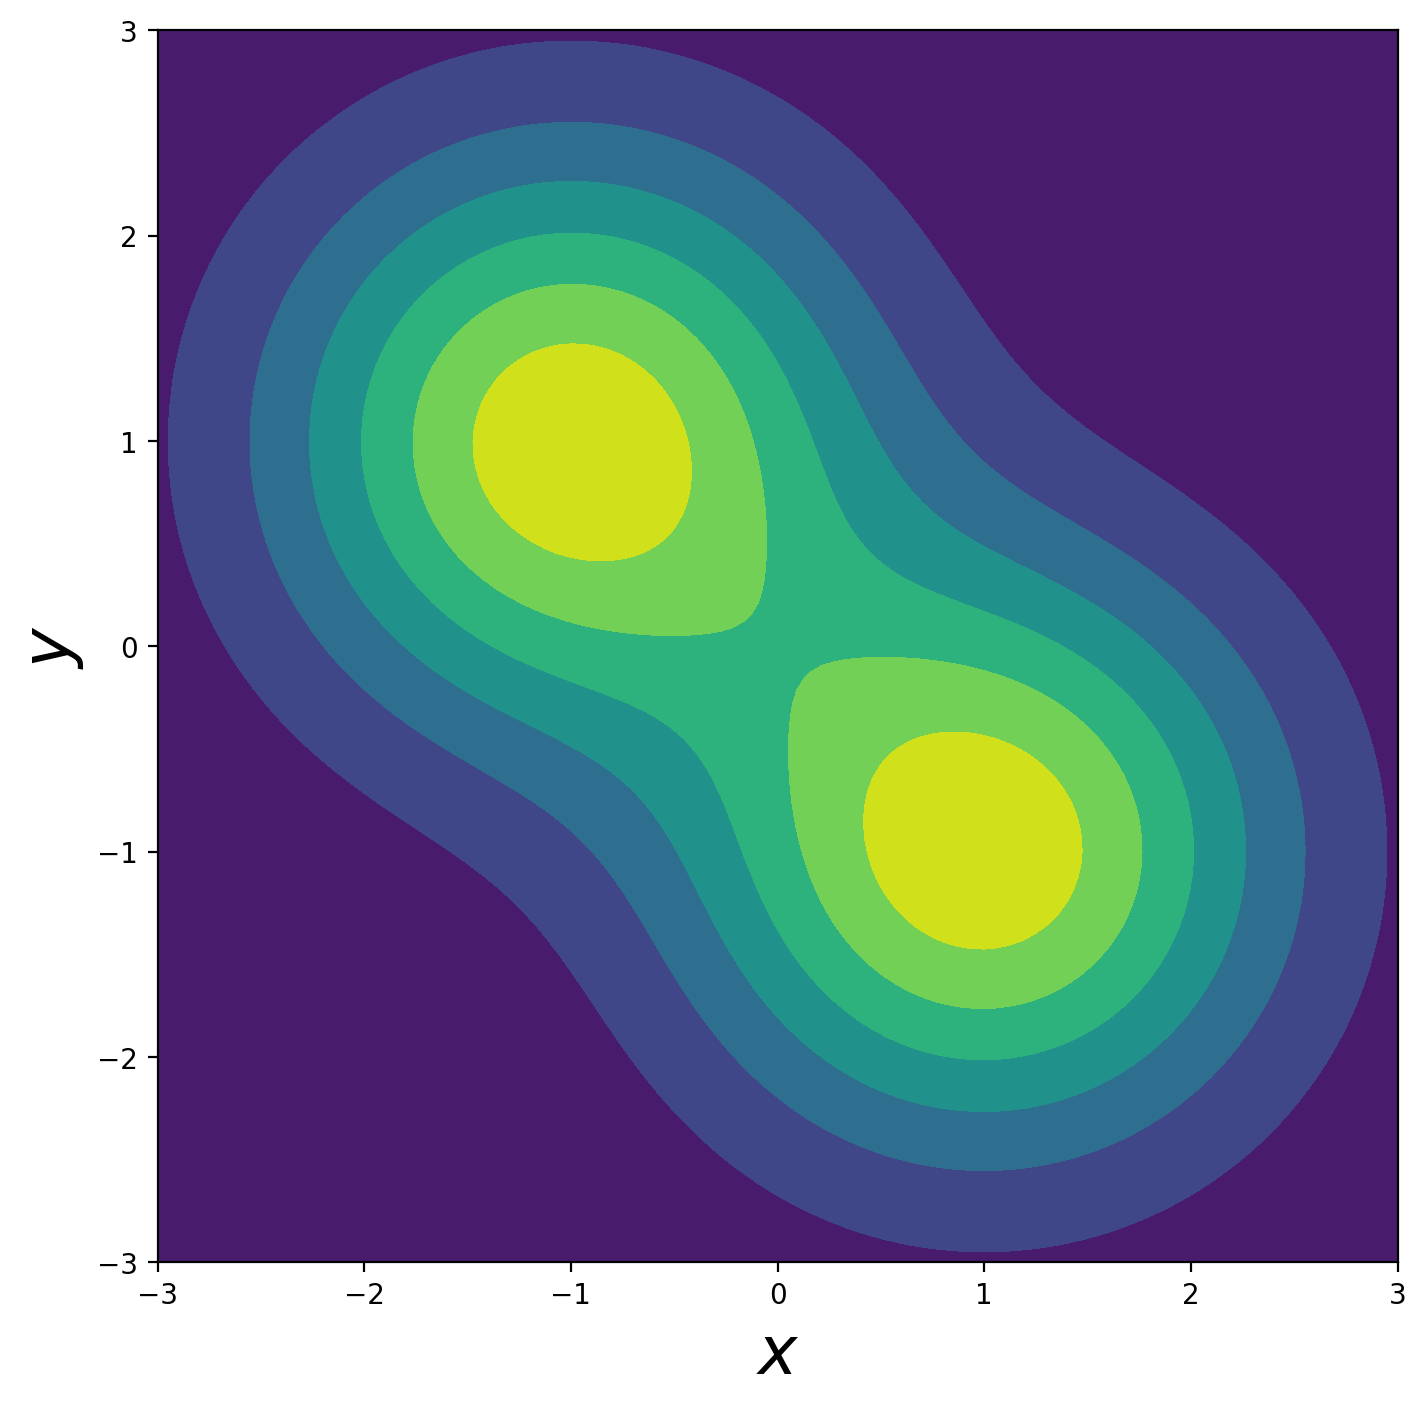

In [2]:
xplot = linspace(-3, 3, 100)
yplot = linspace(-3, 3, 100)
sigma = 1.
x1, y1 = -1., 1.
x2, y2 = 1., -1
mode1 = exp(-((xplot[None, :] - x1)**2 + (yplot[:, None] - y1)**2)/(2*sigma**2))
mode2 = exp(-((xplot[None, :] - x2)**2 + (yplot[:, None] - y2)**2)/(2*sigma**2))
p_unnormalized = mode1 + mode2

figure(1, [8, 8])
# pcolor(xplot, yplot, p_unnormalized)
contourf(xplot, yplot, p_unnormalized)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# What would a Markov chain that has "perfectly" correlated steps look like?

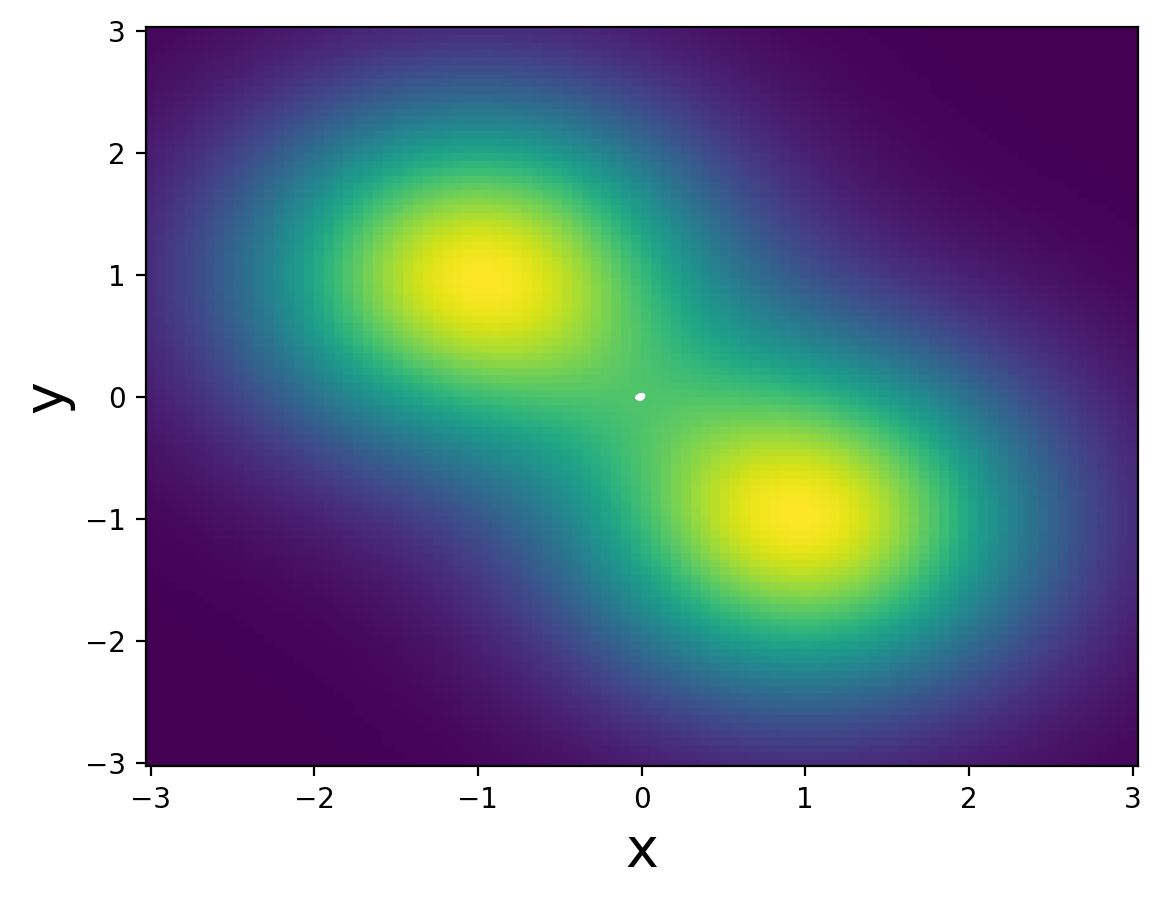

In [3]:
def target_density(X):
    x = X[..., 0]
    y = X[..., 1]
    sigma = 1.
    x1, y1 = -1., 1.
    x2, y2 = 1., -1
    mode1 = exp(-((x - x1)**2 + (y - y1)**2)/(2*sigma**2))
    mode2 = exp(-((x - x2)**2 + (y - y2)**2)/(2*sigma**2))
    p_unnormalized = mode1 + mode2
    return p_unnormalized

def proposal_density(x, x0):
    pX = stats.norm.pdf(x[..., 0], x0[..., 0], sigma)
    pY = stats.norm.pdf(x[..., 1], x0[..., 1], sigma)
    return pX*pY

Nsteps = 400
Nchains = 2
sigma = 0.001

x0, y0 = 0., 0.

x = zeros([Nchains, Nsteps, 2])
x[:, :, 0] = x0
x[:, :, 1] = y0

for t in arange(1, Nsteps):
    xold = x[:, t-1, :]
    xhat = normal(xold, sigma)
    pMH = (target_density(xhat)*proposal_density(xold, xhat)/
          (target_density(xold)*proposal_density(xhat, xold)))
    pMH = minimum(1, pMH)
    u = rand(Nchains)
    chi = u < pMH
    x[:, t, :] = xhat*chi + xold*(1 - chi)

plot(x[0, :, 0], x[0, :, 1], 'w'); # first chain
# plot(x[1, :]); # second chain
pcolor(xplot, yplot, p_unnormalized)
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

# What happens if we take bigger steps?
# We should have less correlation between steps
# We should explore the target distribution more completely, right?

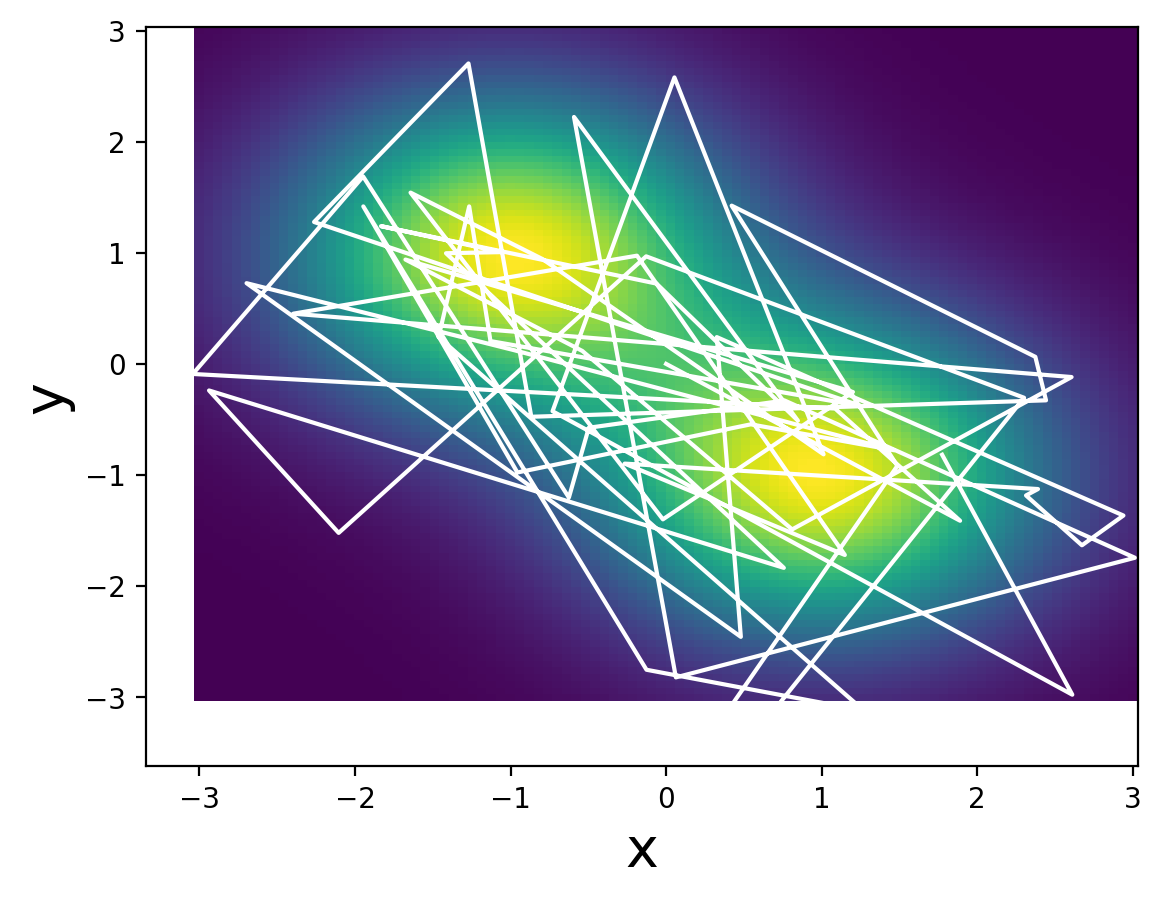

In [4]:
def target_density(X):
    x = X[..., 0]
    y = X[..., 1]
    sigma = 1.
    x1, y1 = -1., 1.
    x2, y2 = 1., -1
    mode1 = exp(-((x - x1)**2 + (y - y1)**2)/(2*sigma**2))
    mode2 = exp(-((x - x2)**2 + (y - y2)**2)/(2*sigma**2))
    p_unnormalized = mode1 + mode2
    return p_unnormalized

def proposal_density(x, x0):
    pX = stats.norm.pdf(x[..., 0], x0[..., 0], sigma)
    pY = stats.norm.pdf(x[..., 1], x0[..., 1], sigma)
    return pX*pY

Nsteps = 400
Nchains = 1
sigma = 4.

x0, y0 = 0., 0.

x = zeros([Nchains, Nsteps, 2])
x[:, :, 0] = x0
x[:, :, 1] = y0

acceptance_history = zeros([Nchains, Nsteps])

for t in arange(1, Nsteps):
    xold = x[:, t-1, :]
    xhat = normal(xold, sigma)
    pMH = (target_density(xhat)/
          (target_density(xold)))
    pMH = minimum(1, pMH)
    u = rand(Nchains)
    chi = u < pMH
    acceptance_history[:, t] = chi
    x[:, t, :] = xhat*chi + xold*(1 - chi)

plot(x[0, :, 0], x[0, :, 1], 'w'); # first chain
# plot(x[1, :]); # second chain
pcolor(xplot, yplot, p_unnormalized)
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

In [5]:
acceptance_history.sum()/Nsteps

0.16

## Our acceptance ratio drops as we take larger steps.

## This problem is substantially amplified as we increase the dimension

# Small steps could lead to metastable transitions between regions of the target distribution

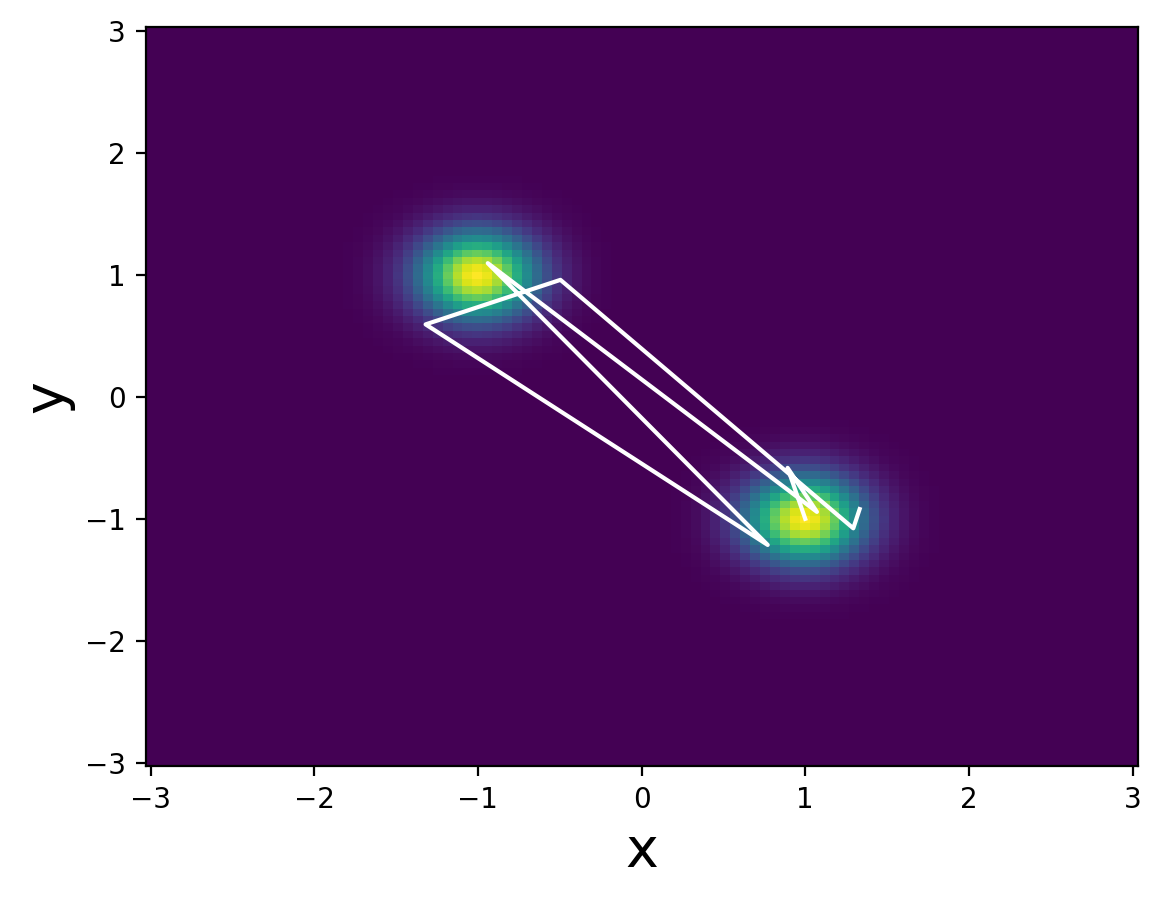

In [6]:
def plot_target(sigma=1.):
    xplot = linspace(-3, 3, 100)
    yplot = linspace(-3, 3, 100)
    x1, y1 = -1., 1.
    x2, y2 = 1., -1
    mode1 = exp(-((xplot[None, :] - x1)**2 + (yplot[:, None] - y1)**2)/(2*sigma**2))
    mode2 = exp(-((xplot[None, :] - x2)**2 + (yplot[:, None] - y2)**2)/(2*sigma**2))
    p_unnormalized = mode1 + mode2

    figure(1, [8, 8])
    pcolor(xplot, yplot, p_unnormalized)
    #contourf(xplot, yplot, p_unnormalized)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$y$', fontsize=24);
def target_density(X):
    x = X[..., 0]
    y = X[..., 1]
    sigma = 0.25
    x1, y1 = -1., 1.
    x2, y2 = 1., -1
    mode1 = exp(-((x - x1)**2 + (y - y1)**2)/(2*sigma**2))
    mode2 = exp(-((x - x2)**2 + (y - y2)**2)/(2*sigma**2))
    p_unnormalized = mode1 + mode2
    return p_unnormalized

def proposal_density(x, x0):
    pX = stats.norm.pdf(x[..., 0], x0[..., 0], sigma)
    pY = stats.norm.pdf(x[..., 1], x0[..., 1], sigma)
    return pX*pY

Nsteps = 400
Nchains = 1
sigma = 4.

x0, y0 = 1., -1

x = zeros([Nchains, Nsteps, 2])
x[:, :, 0] = x0
x[:, :, 1] = y0

acceptance_history = zeros([Nchains, Nsteps])

for t in arange(1, Nsteps):
    xold = x[:, t-1, :]
    xhat = normal(xold, sigma)
    pMH = (target_density(xhat)*proposal_density(xold, xhat)/
          (target_density(xold)*proposal_density(xhat, xold)))
    pMH = minimum(1, pMH)
    u = rand(Nchains)
    chi = u < pMH
    acceptance_history[:, t] = chi
    x[:, t, :] = xhat*chi + xold*(1 - chi)

plot(x[0, :, 0], x[0, :, 1], 'w'); # first chain
# plot(x[1, :]); # second chain
plot_target(sigma=0.25)
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

In [7]:
acceptance_history.sum()/Nsteps

0.02

# Important properties of estimation using Markov chains
If we have a well behaved (we will define this later) Markov chain with a sufficiently large number of sample steps, an estimator satisfies a central limit theorem
$$\hat{f}_N \sim \text{Normal}(E[f], \mathcal{E}_N)$$
where $\mathcal{E}_N$ is the standard error
$$\mathcal{E}_N = \sqrt{\frac{\text{Var}[f]}{S_N}},$$
where $S_N$ is the *effective sample size*
$$S_N = \frac{N}{1 + 2\sum_{l=1}^{\infty}\rho_l}, $$
where $\rho_l$ is the lag $l$ [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) of $f$ over the history of the Markov chain.


## The take home message is that the more correlated the steps of the chain are, the more steps you need for expectations to converge

# Where should we distribute our samples?
Consider a region around the mode or peak of a probability density. Which will generically have spherical geometry (at least locally).

## Should we place the number of samples to be proportional to the target density?

While this might tempting to believe on an intuitive level. It turns out to be wrong.

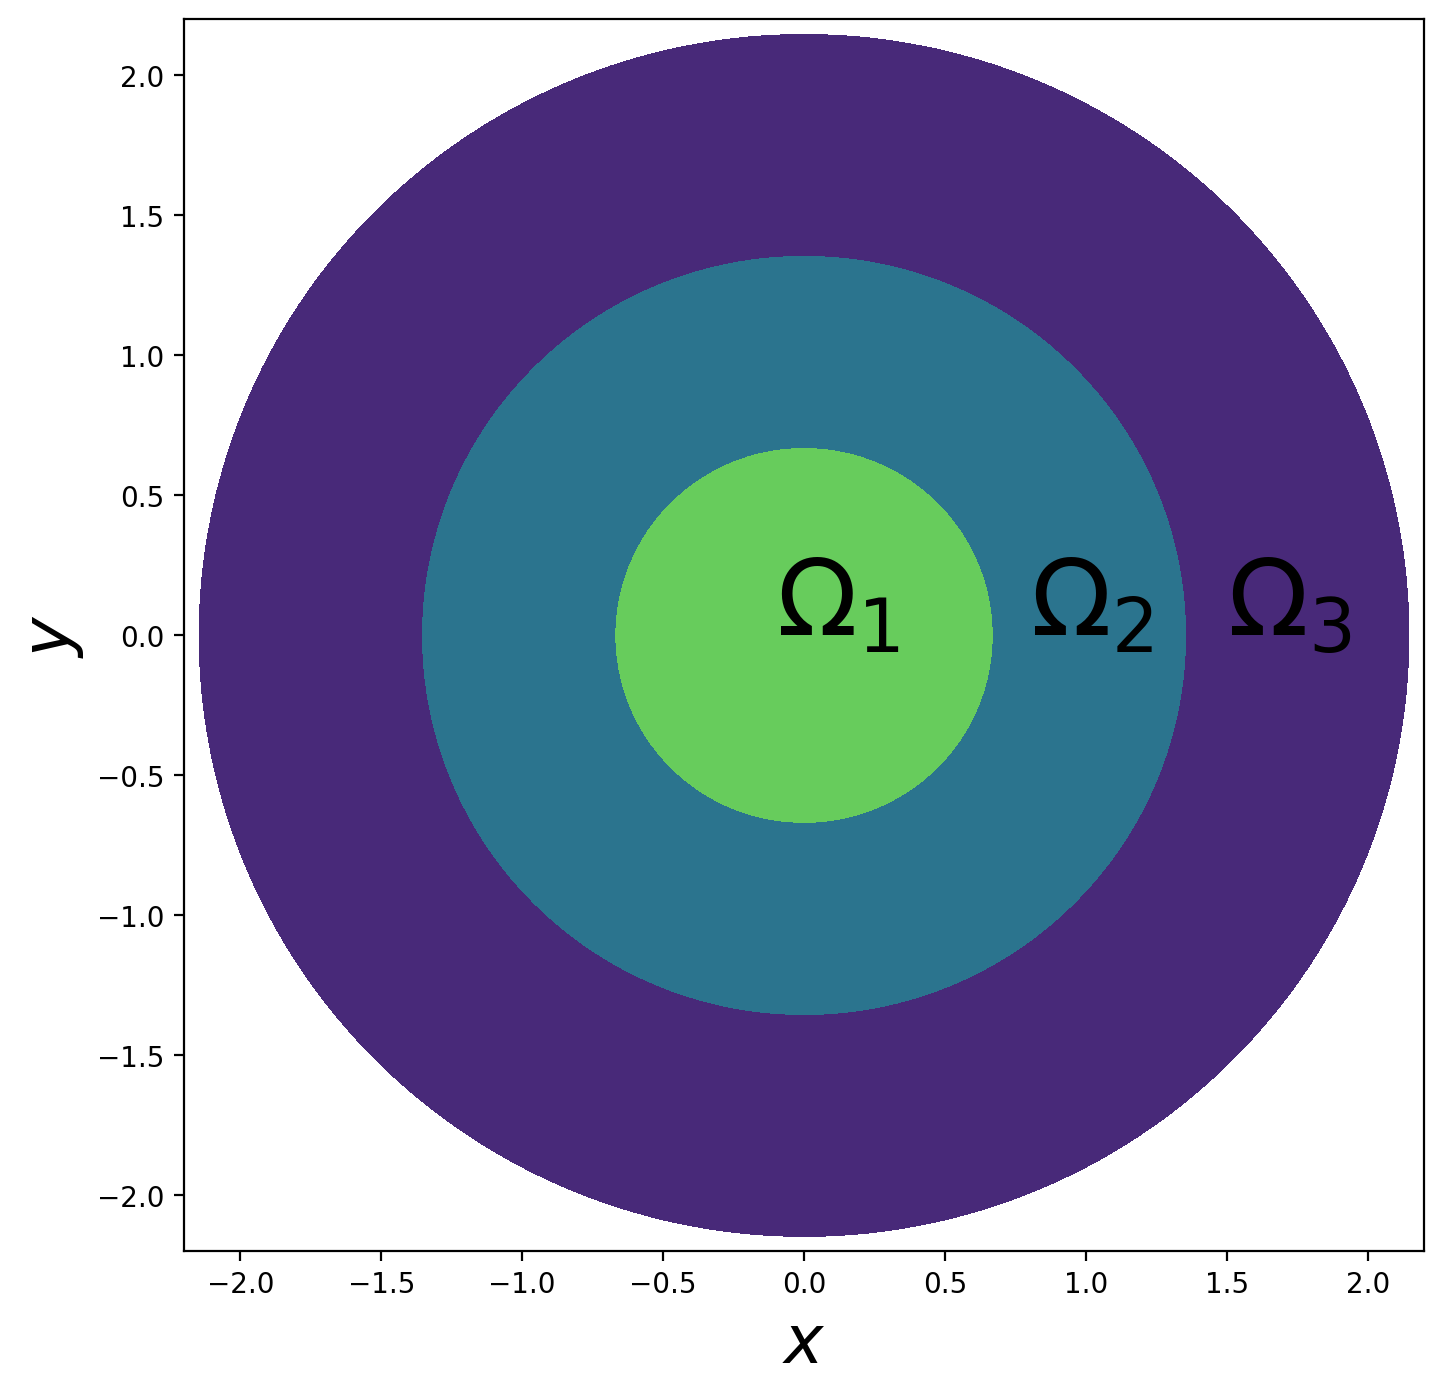

In [8]:
xplot = linspace(-2.2, 2.2, 100)
yplot = linspace(-2.2, 2.2, 100)
sigma = 1.
x1, y1 = 0., 0.

mode1 = exp(-((xplot[None, :] - x1)**2 + (yplot[:, None] - y1)**2)/(2*sigma**2))
p_unnormalized = mode1

figure(1, [8, 8])
# pcolor(xplot, yplot, p_unnormalized)
contourf(xplot, yplot, p_unnormalized, [0.1, 0.4, 0.8, 1.4])
text(-0.1, 0, r'$\Omega_1$', fontsize=38)
text(0.8, 0, r'$\Omega_2$', fontsize=38)
text(1.5, 0, r'$\Omega_3$', fontsize=38)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

## Example: Out of $N$ total samples, how many should go in each region?
For simplicity, suppose we have a piecewise constant density
$$
p(x) =
\begin{cases}
p_1, & x\in \Omega_1 \\
p_2, & x\in \Omega_2 \\
p_3, & x\in \Omega_3 \\
\end{cases}
$$
where $p_1 > p_2 > p_3$.

Suppose we want to estimate
\begin{align*}
E[\mathbb{1}(x\in\Omega_j)] &= \int_{\Omega} \mathbb{1}(x\in\Omega_j) p(x) dx \\
 &= p_j\int_{\Omega_j} dx = p_j \text{Area}(\Omega_j)
\end{align*}

With the empirical sample approximation
$$
E[\mathbb{1}(x\in\Omega_j)] \approx \frac{1}{N}\sum_{i=1}^{N}\mathbb{1}(x_i\in\Omega_j).
$$
In other words, the above expectation is the fraction of the total number of samples that lie in the region $\Omega_j$.

### Region $\Omega_2$ might have a lower probability **density** than $\Omega_1$, but it also has a much larger area (or volume in higher dimensions)

Let's plug in some numbers to explore this further. Suppose
$$ \frac{p_1}{p_2} = 10,$$
that is, the probability density is 10 times larger in region $\Omega_1$ relative to $\Omega_2$.

Suppose the radius of $\Omega_1$ is $r_1=1$ and the radius of $\Omega_2$ is $r_2 > 1$. The ratio of the number of samples in each region should be
$$ \frac{p_1\text{Area}(\Omega_1)}{p_2\text{Area}(\Omega_2)}
=  \frac{p_1 \pi }{p_2(\pi r_2^2 - \pi) }
=  \frac{10 }{ r_2^2 - 1}
$$
 We can see that if $r_2=2$, we should expect to have $10/3 \approx 3.33$ times as many samples in $\Omega_1$ compared to $\Omega_2$. By increasing $r_2$, we could reach a point where there should be fewer samples in $\Omega_1$ than $\Omega_2$! (This happens at $r_2=\sqrt{11}\approx 3.3$.)

In $d$ dimensions (i.e., $x\in \mathbb{R}^d$) the ratio becomes
$$ \frac{p_1\text{Vol}(\Omega_1)}{p_2\text{Vol}(\Omega_2)}
=  \frac{10}{ r_2^d - 1}.
$$
Hence, the number of samples in $\Omega_1$ compared to $\Omega_2$ is an *exponentially decreasing* function of the $d$.

# How does volume behave in in high dimensional spaces?
## Picture a unit sphere inside a unit cube
The Volume of the unit cube is identically one in any dimension.

The volume of the unit circle is
$$V_2 = \pi$$
The volume of the unit sphere is
$$V_3 = \frac{4}{3}\pi $$
The volume of the unit hypersphere in $d$ dimensions is
$$ V_d = \frac{\pi^{d/2}}{\left(\frac{d}{2}\right)!} $$

## For large dimension $d$, the volume of the unit sphere decreases exponentially compared to the unit cube... Weird!

# Where should we place samples to best "see" most of the probability?
## Definition: typical sets
  1. The volume in any neighborhood containing the mode (peak) becomes more and more negligible as the dimension of the parameter space increases
  2. The neighborhood immediately around the mode features large densities, but in high dimensions the small volume of that neighborhood prevents it from having much contribution to any expectation
  3. On the other hand, the regions far away from the mode have a much larger volume, but the exponentially decreasing probability density leads to similarly negligible contributions to expectations

# Thursday: Our goal is to find a proposal transition that addresses the problems we discovered during Monday's lecture

  1. MCMC chains work better as the steps become less correlated and closer to independent
  2. Larger steps do not generally make the steps less correlated because it leads to increased number of rejected steps, which increases auto correlation
  3. In high dimensions, we need to explore **typical sets** which are close, but not too close, to modes of the distribution

# Symmetric proposal distributions cancel out of the acceptance probability
Recall the acceptance probability,
$$p_{MH}(x_t, x_{t-1}) = \min\left\{1, \frac{p(\hat{x})q(x_{t-1} | \hat{x})}{p(x_{t-1})q( \hat{x} | x_{t-1})} \right\}.$$
In some cases, we have a symmetric proposal density where $q(x_t | x_{t-1}) = q(x_{t-1} | x_{t})$. In which case the acceptance probability is independent of the proposal density.
For example
$$ q(x_t | x_{t-1}) = \text{Normal}(x_{t-1}, \sigma)$$
The probabilty density is
$$ G(x | x', \sigma) \propto \exp(-\frac{(x - x')^2}{2\sigma^2)})$$
$$ G(x' | x, \sigma) \propto \exp(-\frac{(x' - x)^2}{2\sigma^2)})$$

# Can we use a proposal transition function based on an ordinary differential equation (ODE)?


$$ \frac{d x}{dt} = \dot{x} = f(x) $$
$$ x_0 = x(0)$$

# Finite differences

$$ \lim_{\Delta t \to 0} \frac{x(t + \Delta t) - x(t)}{\Delta t}  = \dot{x}$$
Suppose we have a fixed parameter $0 < \Delta t \ll 1$
$$ \dot{x} \approx \frac{x(t + \Delta t) - x(t)}{\Delta t}  $$


$$\dot{x} = f(x)$$
$$ \frac{x(t + \Delta t) - x(t)}{\Delta t} \approx f(x(t)) $$
$$ x(t + \Delta t)  \approx x(t) + \Delta t f(x(t)) $$

# Simple numerical ODE: finite differences: Euler's method

$$ x(t + \Delta t) = x(t) + \Delta t f(x(t))$$

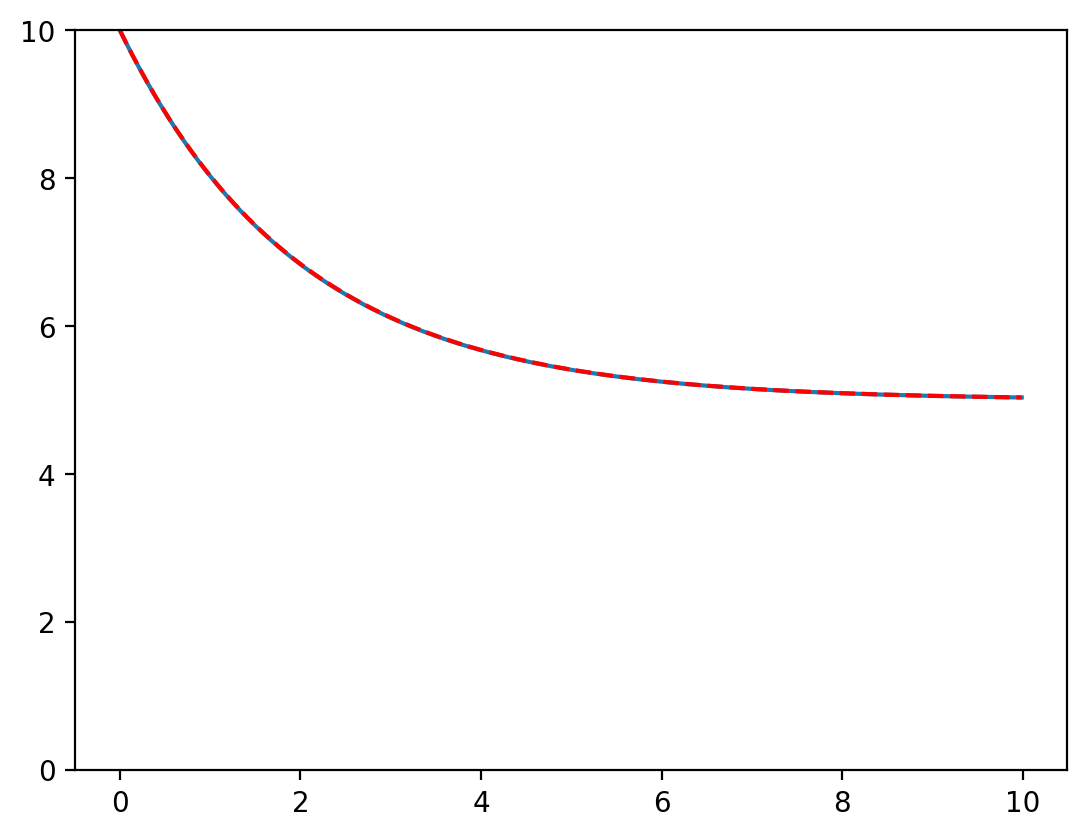

In [9]:
### x' = 0.5*x, x(0) = x_0
### x(t) = x_0*exp(0.5*t)

Nsteps = 1000
dt = 0.01
x0 = 10.
def f(x):
    return 2.5 - 0.5*x


x = zeros((Nsteps))
t = zeros((Nsteps))
x[0] = x0
t[0] = 0.

for n in arange(Nsteps-1):
    x[n+1] = x[n] + dt*f(x[n])
    t[n+1] = t[n] + dt

plot(t, x)
plot(t, (x0 - 5.)*exp(-0.5*t) + 5., '--r')
ylim(0, 10);

# Solutions to ODEs are not random... does this matter?
This is an active area of research

# We could create random steps by making one of the parameters in our ODE a random variable


$$ x(t + \Delta t) = x(t) + \Delta t f(x)$$
$$ \dot{x} = f(x)$$
Make this random by randomizing the initial condition
$$ W \sim \text{Normal}(0, \sqrt{\Delta t}\sigma) $$
$$ x(t + \Delta t) = (x(t) + W) + \Delta t f(x)$$
This can also be written
$$ x(t + \Delta t) \sim \text{Normal}(x(t) + \Delta t f(x), \sqrt{\Delta t}\sigma).$$
The above is a numerical approximation scheme of a *stochastic differential equation*.

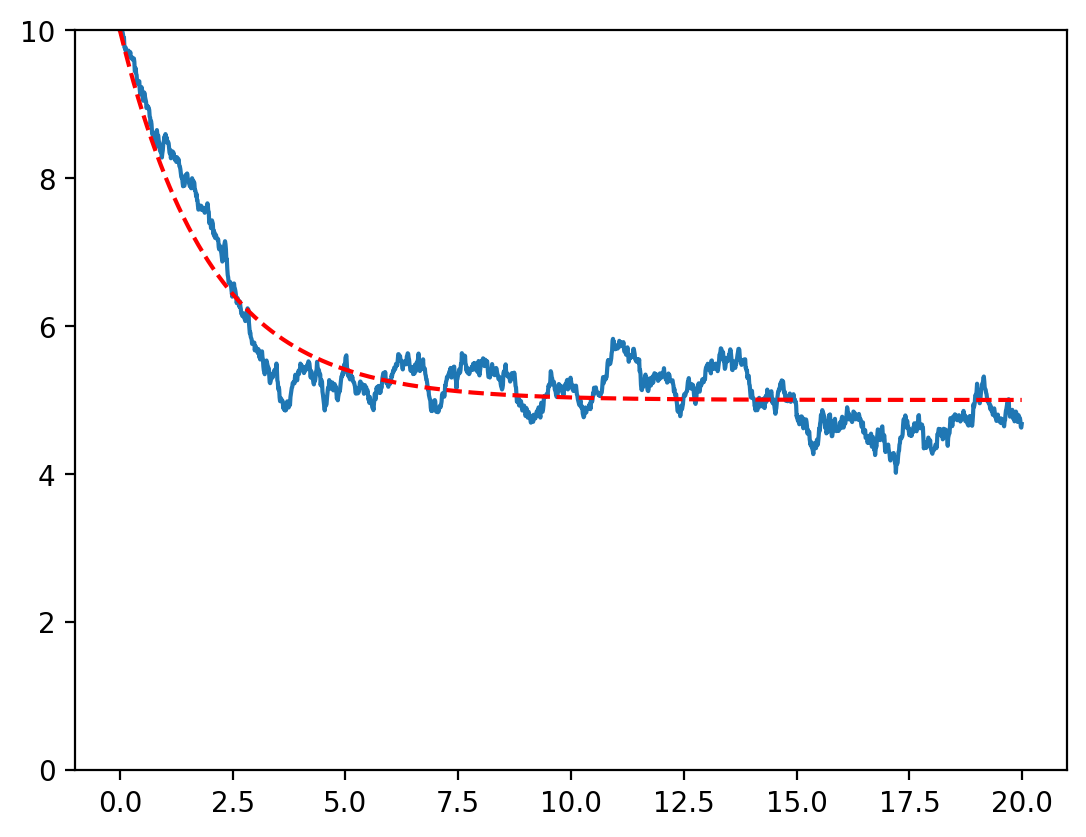

In [10]:
### x' = 0.5*x, x(0) = x_0
### x(t) = x_0*exp(0.5*t)

Nsteps = 2000
dt = 0.01
x0 = 10.
sigma = 0.5

def f(x):
    return 2.5 - 0.5*x


x = zeros((Nsteps))
t = zeros((Nsteps))
x[0] = x0
t[0] = 0.

for n in arange(Nsteps-1):
    x[n+1] = x[n] + dt*f(x[n]) + sqrt(dt)*sigma*normal(0, 1)
    t[n+1] = t[n] + dt

plot(t, x)
plot(t, (x0 - 5.)*exp(-0.5*t) + 5., '--r')
ylim(0, 10);

# A quick side note
Suppose
$$X \sim \text{Normal}(\text{loc}, \text{scale}).$$
The Normal distribution is a member of the [location-scale family](
https://en.wikipedia.org/wiki/Location-scale_family), i.e., it can be
constructed as,
\begin{align*}
X &= \text{loc} + \text{scale}\cdot W, \\
W &\sim \text{Normal}(0, 1).
\end{align*}

In [11]:
?tfd.Normal

# Idea: we want to get our samples into regions where probability is at a high density

## Let's try making an ODE using our log density that points in the direction of steepest increase in density
Our target density is written as
$$\log(Cp(x)) = L(x)$$
$$ Cp(x) = \exp(L(x)) $$
Then we have
$$ W \sim \text{Normal}(0, \sqrt{\Delta t}\sigma) $$
$$ x(t + \Delta t) = (x(t) + W) + \Delta t \nabla L(x)$$

$$ x(t + \Delta t) \sim \text{Normal}(x(t) + \Delta t \nabla L(x), \sqrt{\Delta t}\sigma) $$

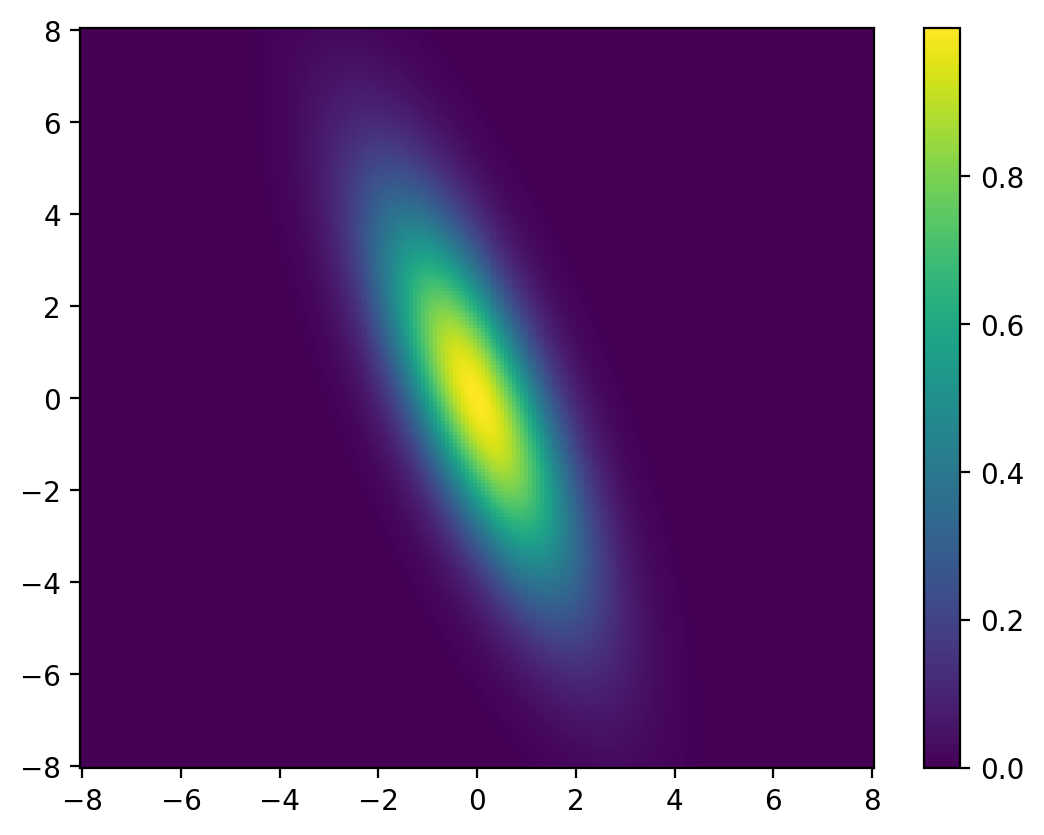

In [12]:
# A = rand(2, 2)
A = array([
    [0.8, 0.05],
    [0.7, 0.5]])
# A = eye(2)


M = A.T@A ## gives me a positive definite matrix for the covariance
def L(_x):
    """Random quadratic form. Input _x assumes rightmost dimension is size 2"""
    xT = _x[..., None, :]
    x = _x[..., None]
    return -0.5*(xT@M@x)[..., 0, 0]

def gradL(x):
    """The exact gradient of a quadratic form"""
    return -(A@x[..., None])[..., 0]

def proposal_density(x, x0, sigma):
    ## Two equivalent versions of a simple normal PDF
    ## 1. TensorFlow probability
    # pX = tfd.Normal(loc=x0[..., 0], scale=sigma).prob(x[..., 0])
    pX = stats.norm.pdf(x[..., 0], x0[..., 0], sigma)
    ## 2. Scipy stats
    pY = stats.norm.pdf(x[..., 1], x0[..., 1], sigma)
    return array(pX*pY)

x = linspace(-8, 8, 200)
y = x
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))
pcolor(X, Y, exp(Z))
colorbar()

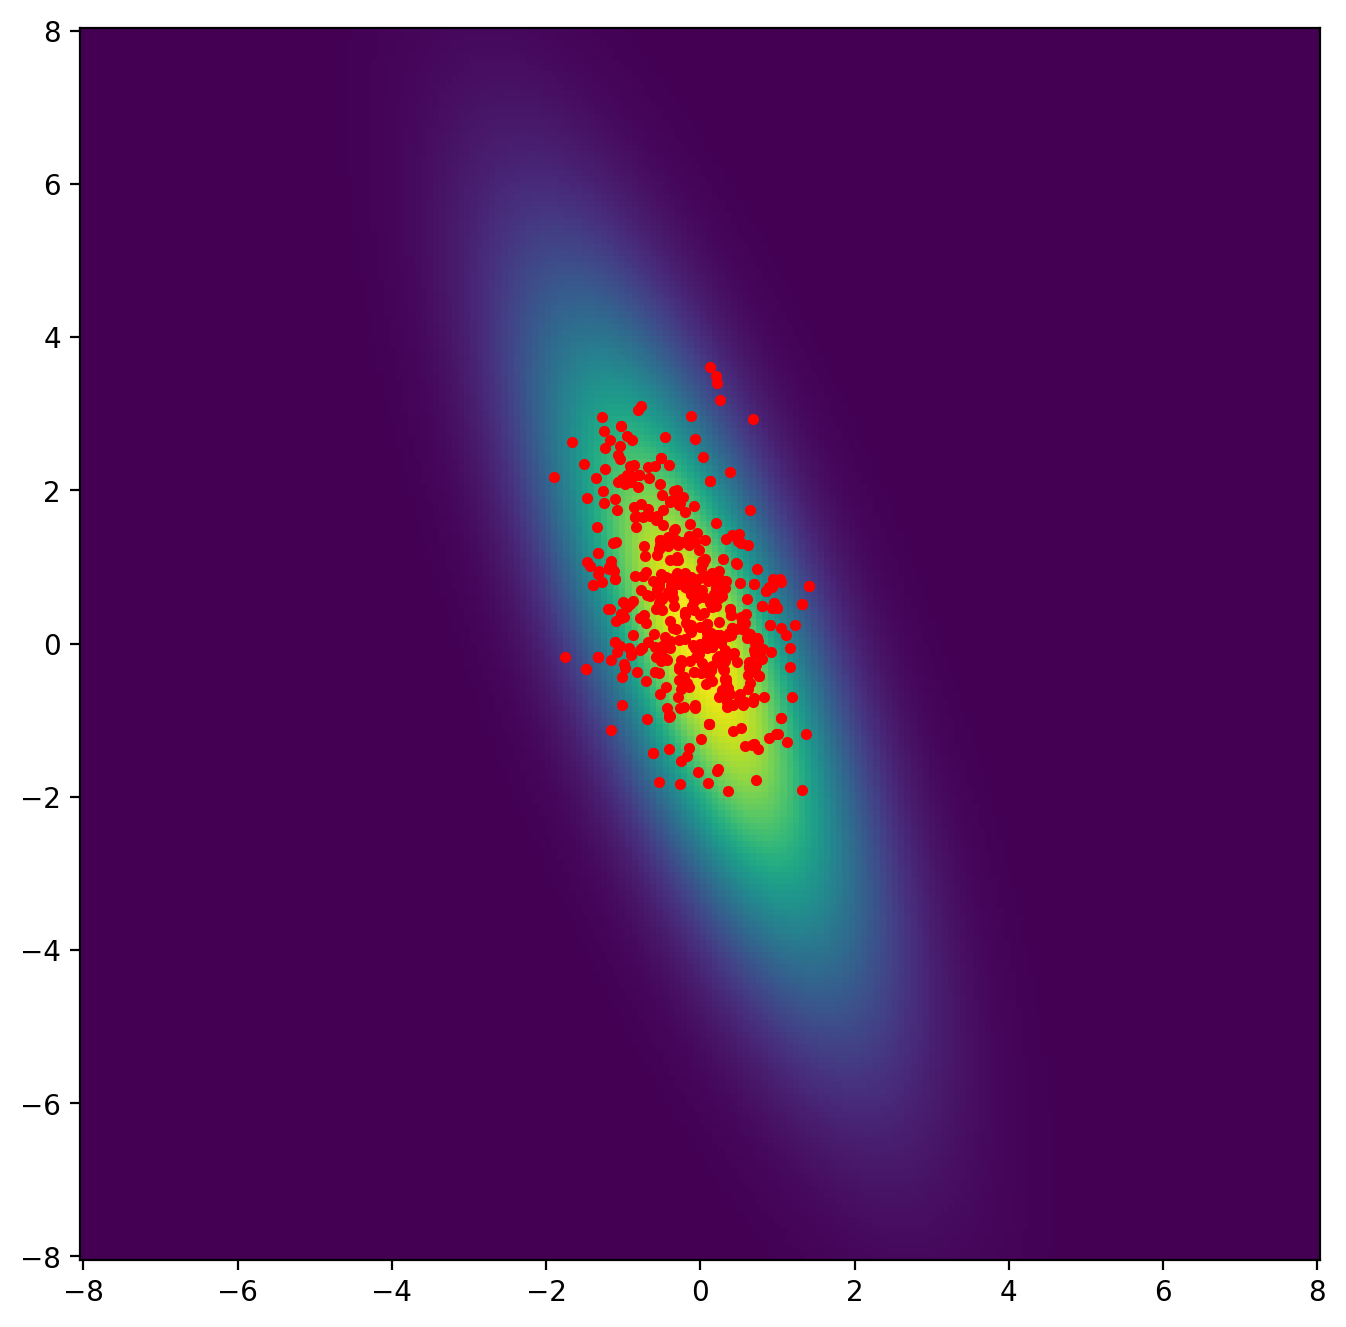

In [13]:
Nsteps = 500
dt = 0.1
sigma = 1.2

x0 = zeros([2])

x = zeros([Nsteps, 2])

for i in arange(Nsteps-1):
    xp = x[i-1] + dt*gradL(x[i-1]) + sigma*normal(0, sqrt(dt), [2])
    proposal_ratio = (
        proposal_density(
            xp, x[i-1] + dt*gradL(x[i-1]), sigma)
        /proposal_density(
            x[i-1], xp + dt*gradL(xp), sigma)
    )
    target_density_ratio = exp(L(xp) - L(x[i-1]))
    pMH = target_density_ratio*proposal_ratio
    chi = rand(1) < pMH
    x[i] = x[i-1]*(1 - chi) + xp*chi
    # if chi == 1:
    #     x[i] = xp
    # else:
    #     x[i] = x[i-1]

figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(x[:, 0], x[:, 1], '.r')

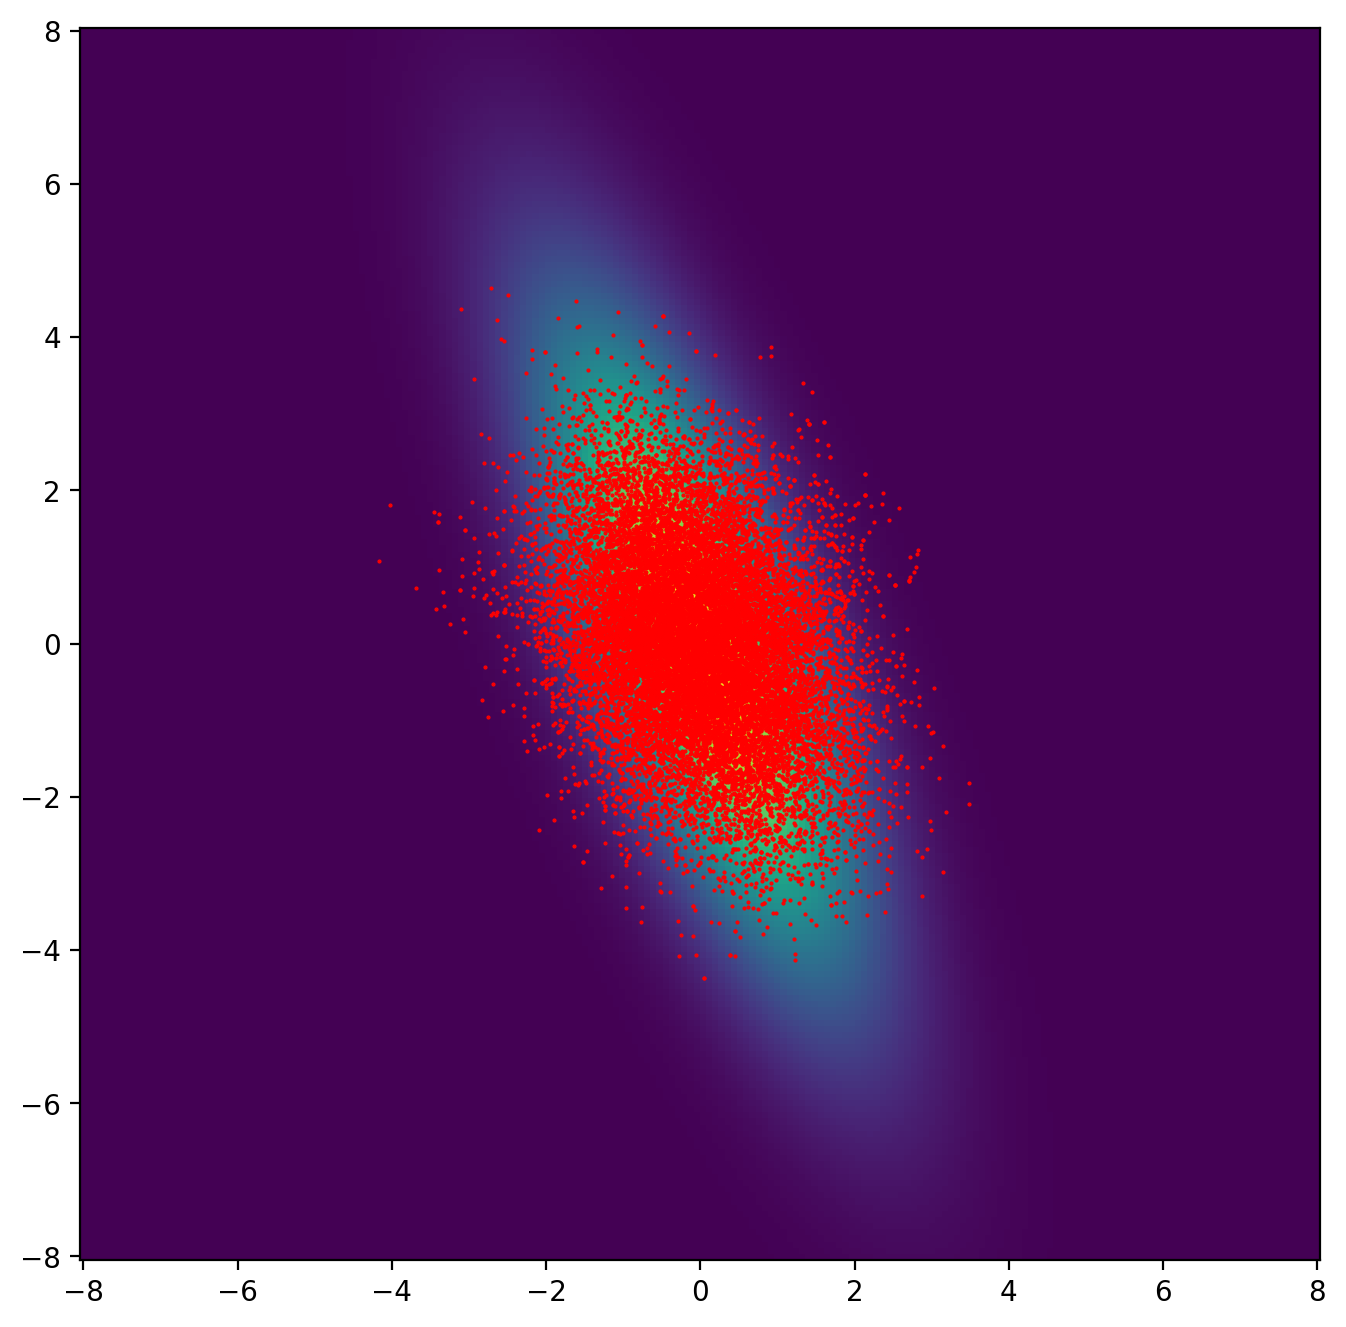

In [14]:
Nsteps = 5000
Nchains = 4
dt = 0.1
sigma = 1.2 ## I can't make the standard deviation any larger; the chain becomes unstable

## initial guess, we do not have to worry about burn in here
x = 0.8*ones((Nchains, 2))


Xchain = zeros((Nsteps, Nchains, 2))
Xchain[0, ...] = x ## use the final value from burin-in phase as new initial guess
probs = zeros((Nsteps, Nchains))
acceptances = ones((Nsteps, Nchains))

for n in arange(Nsteps-1):
    x0 = Xchain[n, ...]
    dW = normal(0, sqrt(dt), [Nchains, 2])
    x = x0 + dt*gradL(x0) + sigma*dW
    ## proposal is not symmetric this time
    proposal_ratio = (
        proposal_density(x, x0 + dt*gradL(x0), sqrt(dt)*sigma)
        /proposal_density(x0, x + dt*gradL(x), sqrt(dt)*sigma) # switch x and x0
    )
    target_density_ratio = exp(L(x0) - L(x))
    p_MH = target_density_ratio*proposal_ratio
    probs[n, :] = p_MH
    u = rand(Nchains)
    chi = 1.*(u < p_MH)
    acceptances[n+1, :] = chi
    Xchain[n+1, ...] = x0*(1 - chi[:, None]) + x*chi[:, None]

figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(Xchain[..., 0].flatten(), Xchain[..., 1].flatten(), 'r.', ms=1)

acceptance ratio: [0.9314 0.9244 0.9304 0.929 ]


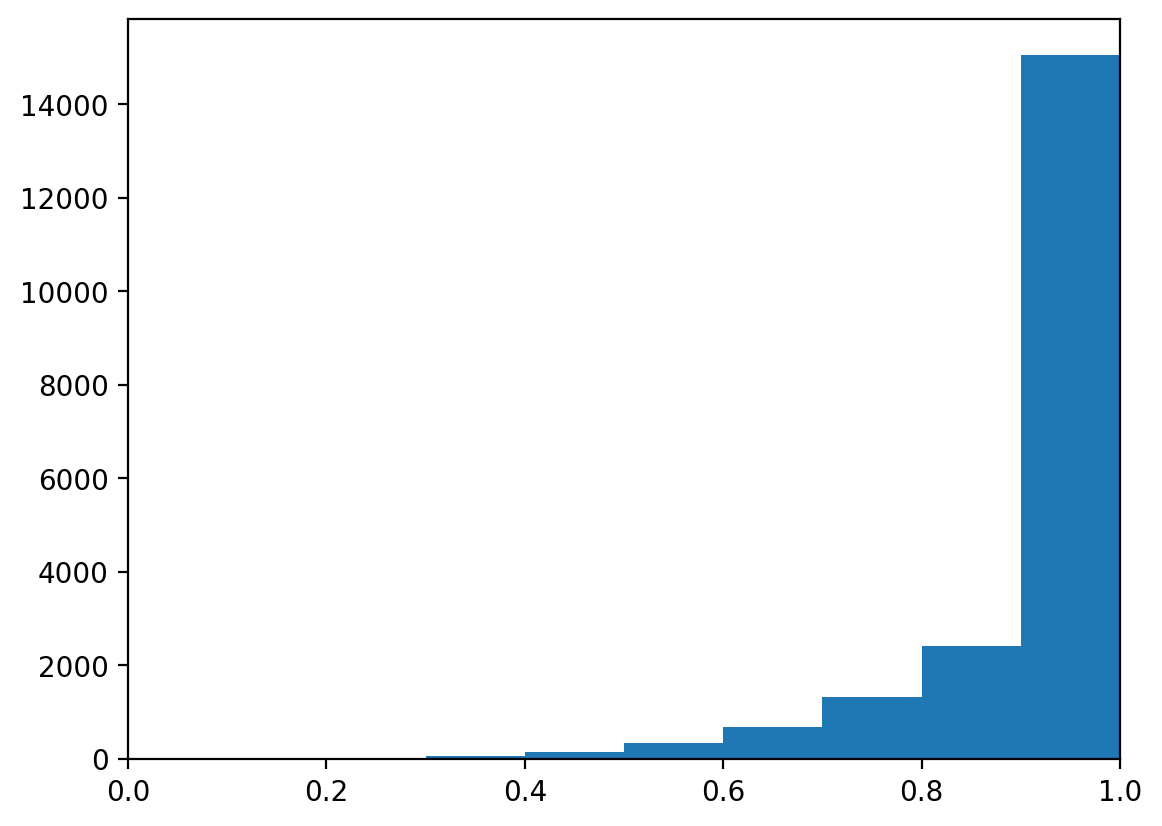

In [15]:
print('acceptance ratio:', acceptances.sum(axis=0)/Nsteps)
hist(probs.clip(0, 1).flatten());
xlim(0, 1);

In [16]:
import tensorflow_probability as tfp
# ?tfp.mcmc.effective_sample_size
# tfp.mcmc.effective_sample_size(normal(0, 1, [1000, 2]))
# tfp.mcmc.effective_sample_size(zeros([100, 2]))
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[264.31217538, 169.55177526],
       [306.75030483, 185.0947234 ],
       [262.72997184, 181.66888598],
       [207.6496104 , 169.28825023]])>

## The resulting estimate of the mean is good, but the covariance is not even close

In [17]:
print('estimated mean:\n', Xchain.mean(axis=(0, 1)))
print('true mean:\n', [0, 0])
print('estimated covariance:\n', cov(Xchain.reshape(-1, 2).T))
print('true covariance:\n', inv(M))

estimated mean:
 [-0.03089462  0.01765653]
true mean:
 [0, 0]
estimated covariance:
 [[ 0.8650252  -0.35979486]
 [-0.35979486  1.50726294]]
true covariance:
 [[ 1.89528992 -2.9273785 ]
 [-2.9273785   8.48189154]]


In [18]:
## convergence of the estimated mean
sqrt(1.89528992)/sqrt(5000)

0.019469411495985182

# TensorFlow Version?

# Problem: our samples will be highly concentrated near modes
This might not be a big problem for our 2D example, but it will become an issue in higher dimensions

$$\frac{dx}{dt}  = \nabla_x L(x(t))$$

# We need a law of motion that lets us explore typical sets. Let's try giving our chain "momentum"
\begin{align*}
 \frac{dx}{dt} & = p(t)\\
 \frac{dp}{dt} &= \nabla_x L(x(t)).
\end{align*}

In [19]:
def H(x, p):
    """Hamiltonian"""
    return -L(x) + 0.5*(p**2).sum(axis=-1)

# Leap-Frog integrator (finite difference method)
Let $x_k = x(k\Delta t)$ and $p_k = p(k\Delta t)$. Then, we can write the method as an iterative formula.

$$\hat{p}_0 = p_0 + 0.5\Delta t \nabla L (x_{0}) $$
For $k=1,2, \ldots, K$:
\begin{align}
x_{k+1} &= x_k + \Delta t \hat{p}_k, \\
\hat{p}_{k+1} &= \hat{p}  + \Delta t \nabla L (x_{k+1}).
\end{align}

In [20]:
A = array([
    [0.8, 0.05],
    [0.7, 0.5]])
# A = eye(2)


M = A.T@A ## gives me a positive definite matrix for the covariance
def L(_x):
    """Random quadratic form. Input _x assumes rightmost dimension is size 2"""
    xT = _x[..., None, :]
    x = _x[..., None]
    return -0.5*(xT@M@x)[..., 0, 0]

def gradL(x):
    """The exact gradient of a quadratic form"""
    return -(A@x[..., None])[..., 0]

x = linspace(-8, 8, 200)
y = x
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))

total time: 20.0


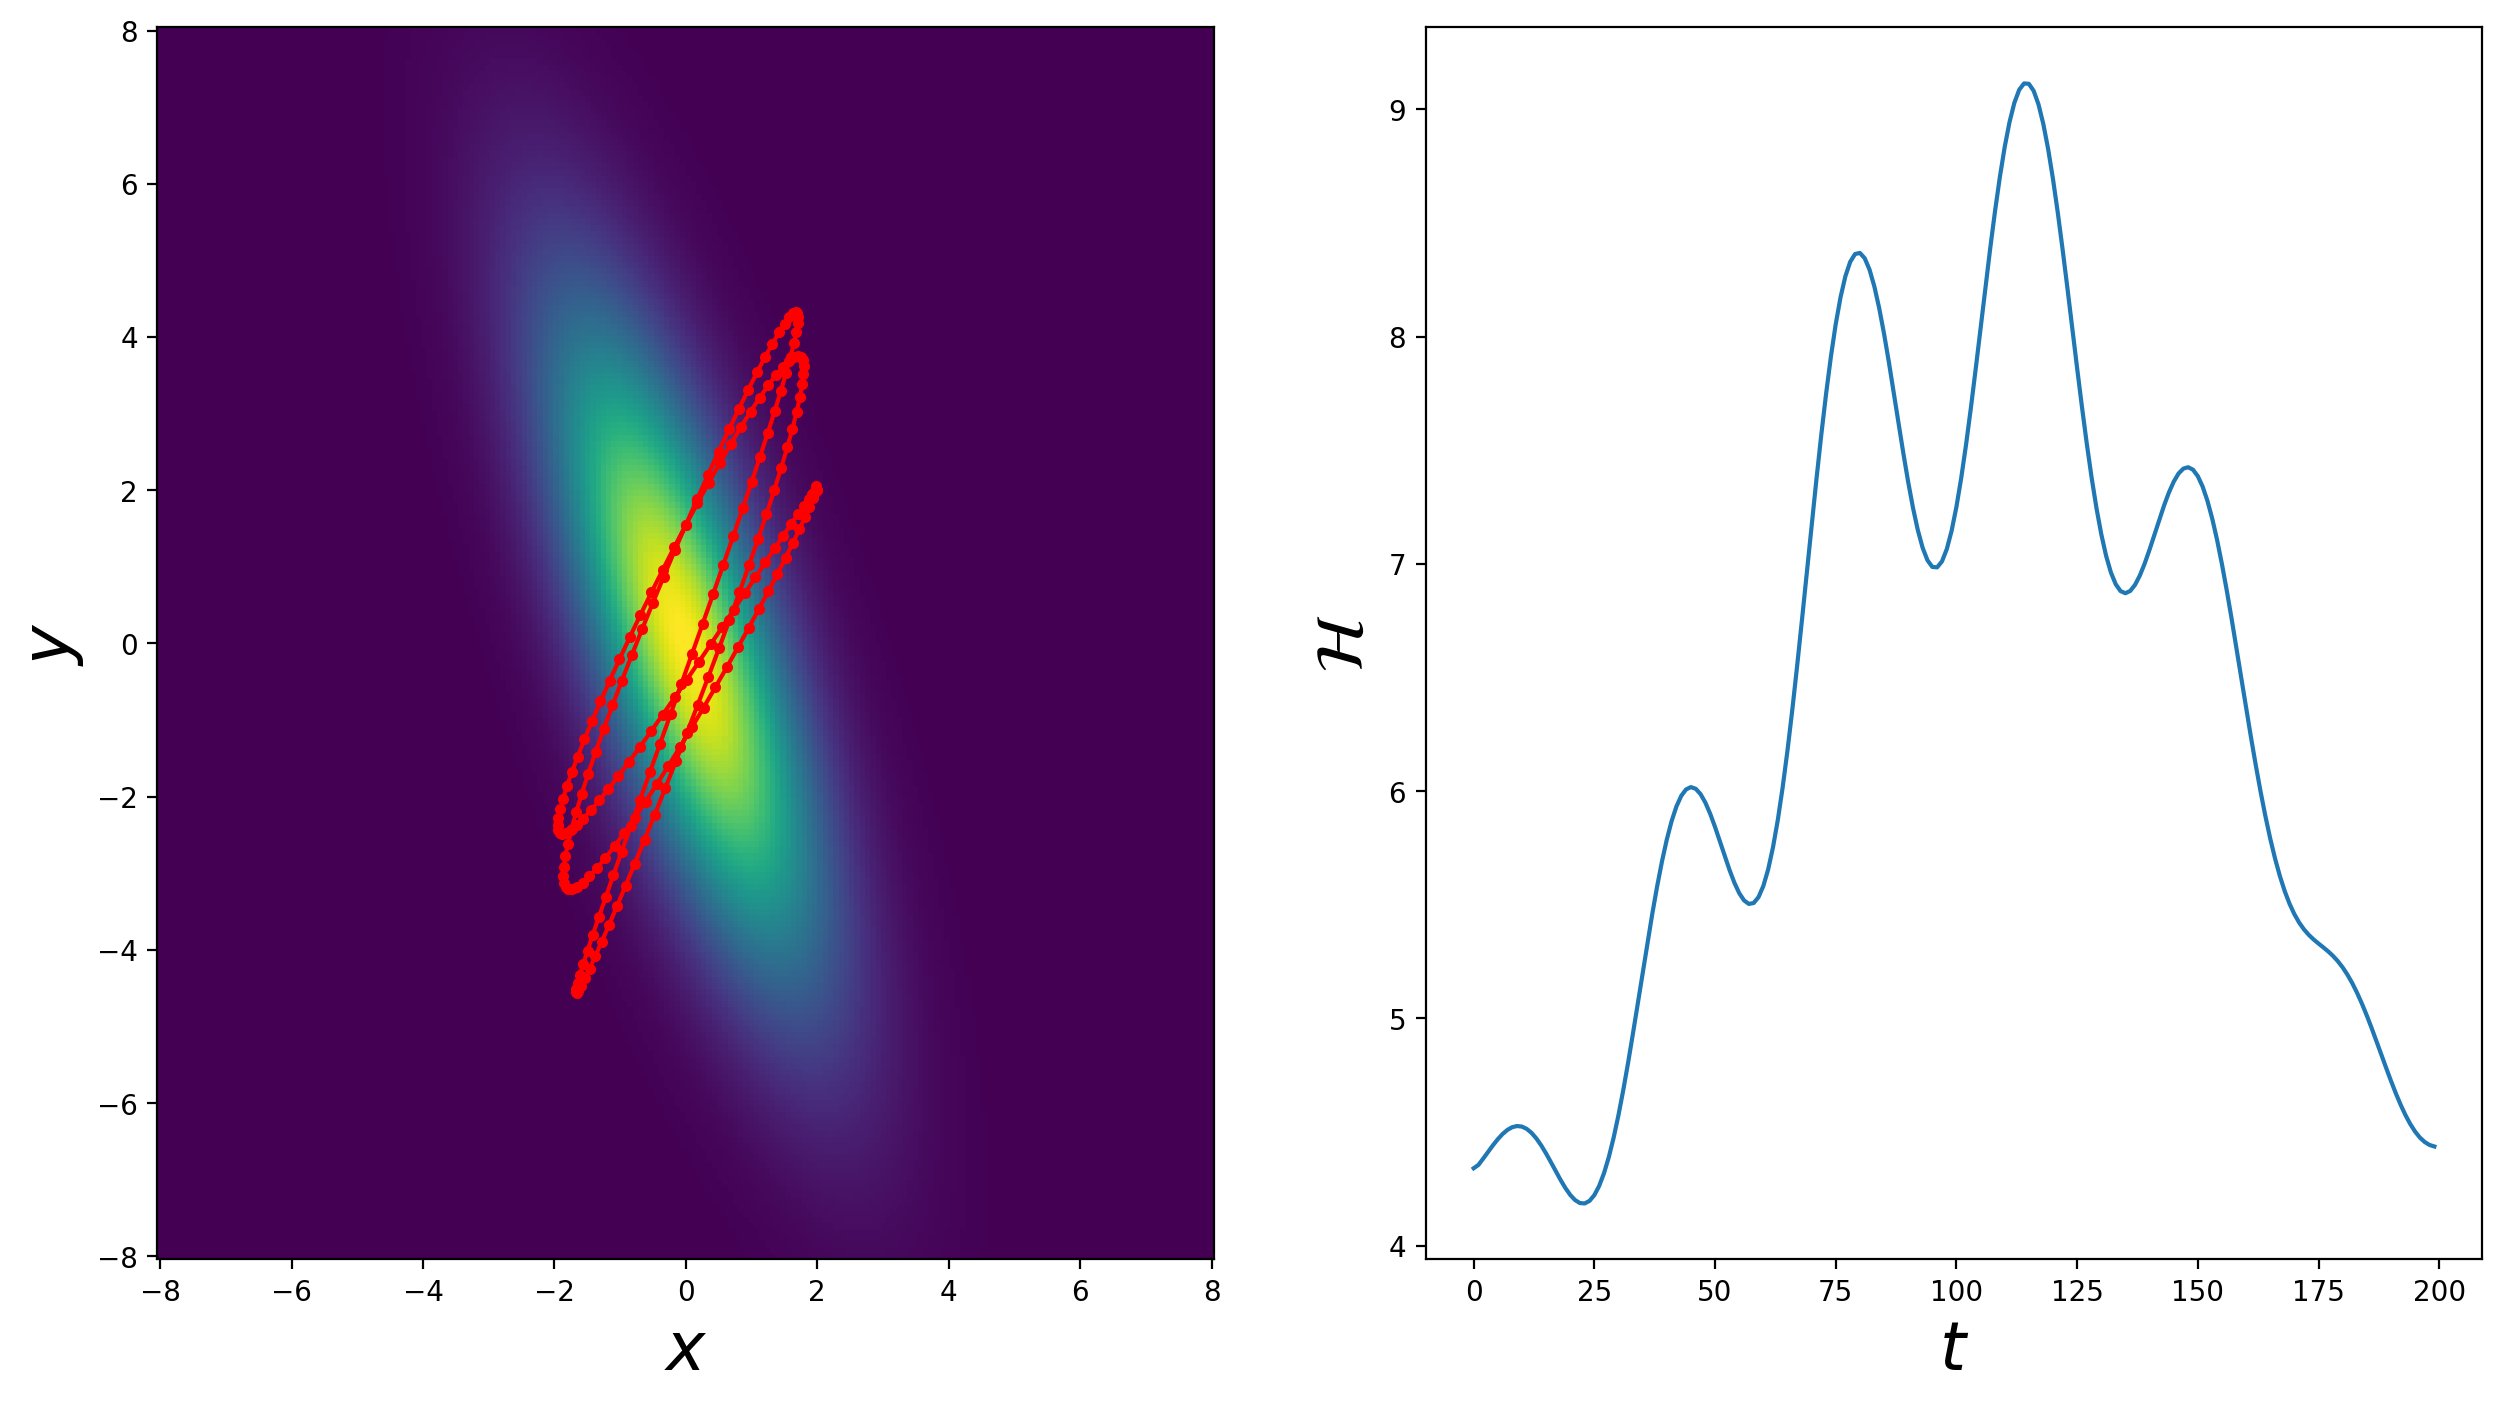

In [21]:
K = 200
dt = 0.1

Xsol = zeros([K, 2])
Psol = zeros([K, 2])

Xsol[0, :] = [2., 2.]
Psol[0, :] = normal(0, 1, [2])

## Euler's method
# for k in arange(K-1):
#     Xsol[k+1, :] = Xsol[k, :] + dt*Psol[k, :]
#     Psol[k+1, :] = Psol[k, :] + dt*gradL(Xsol[k, :])

x = Xsol[0].copy()
p = Psol[0] + 0.5*dt*gradL(x)
for k in arange(1, K):
    x += dt*p
    # same as x = x + dt*p
    p += dt*gradL(x)
    Xsol[k] = x
    Psol[k] = p

print('total time:', K*dt)

fig = figure(1, [15, 8])

fig.add_subplot(121)
pcolor(X, Y, exp(Z))
plot(Xsol[:, 0], Xsol[:, 1], '-r.')
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

fig.add_subplot(122)
plot(H(Xsol, Psol))
xlabel(r'$t$', fontsize=24)
ylabel(r'$\mathcal{H}$', fontsize=24);

interactive(children=(IntSlider(value=100, description='k', max=200, min=100, step=100), Output()), _dom_class…

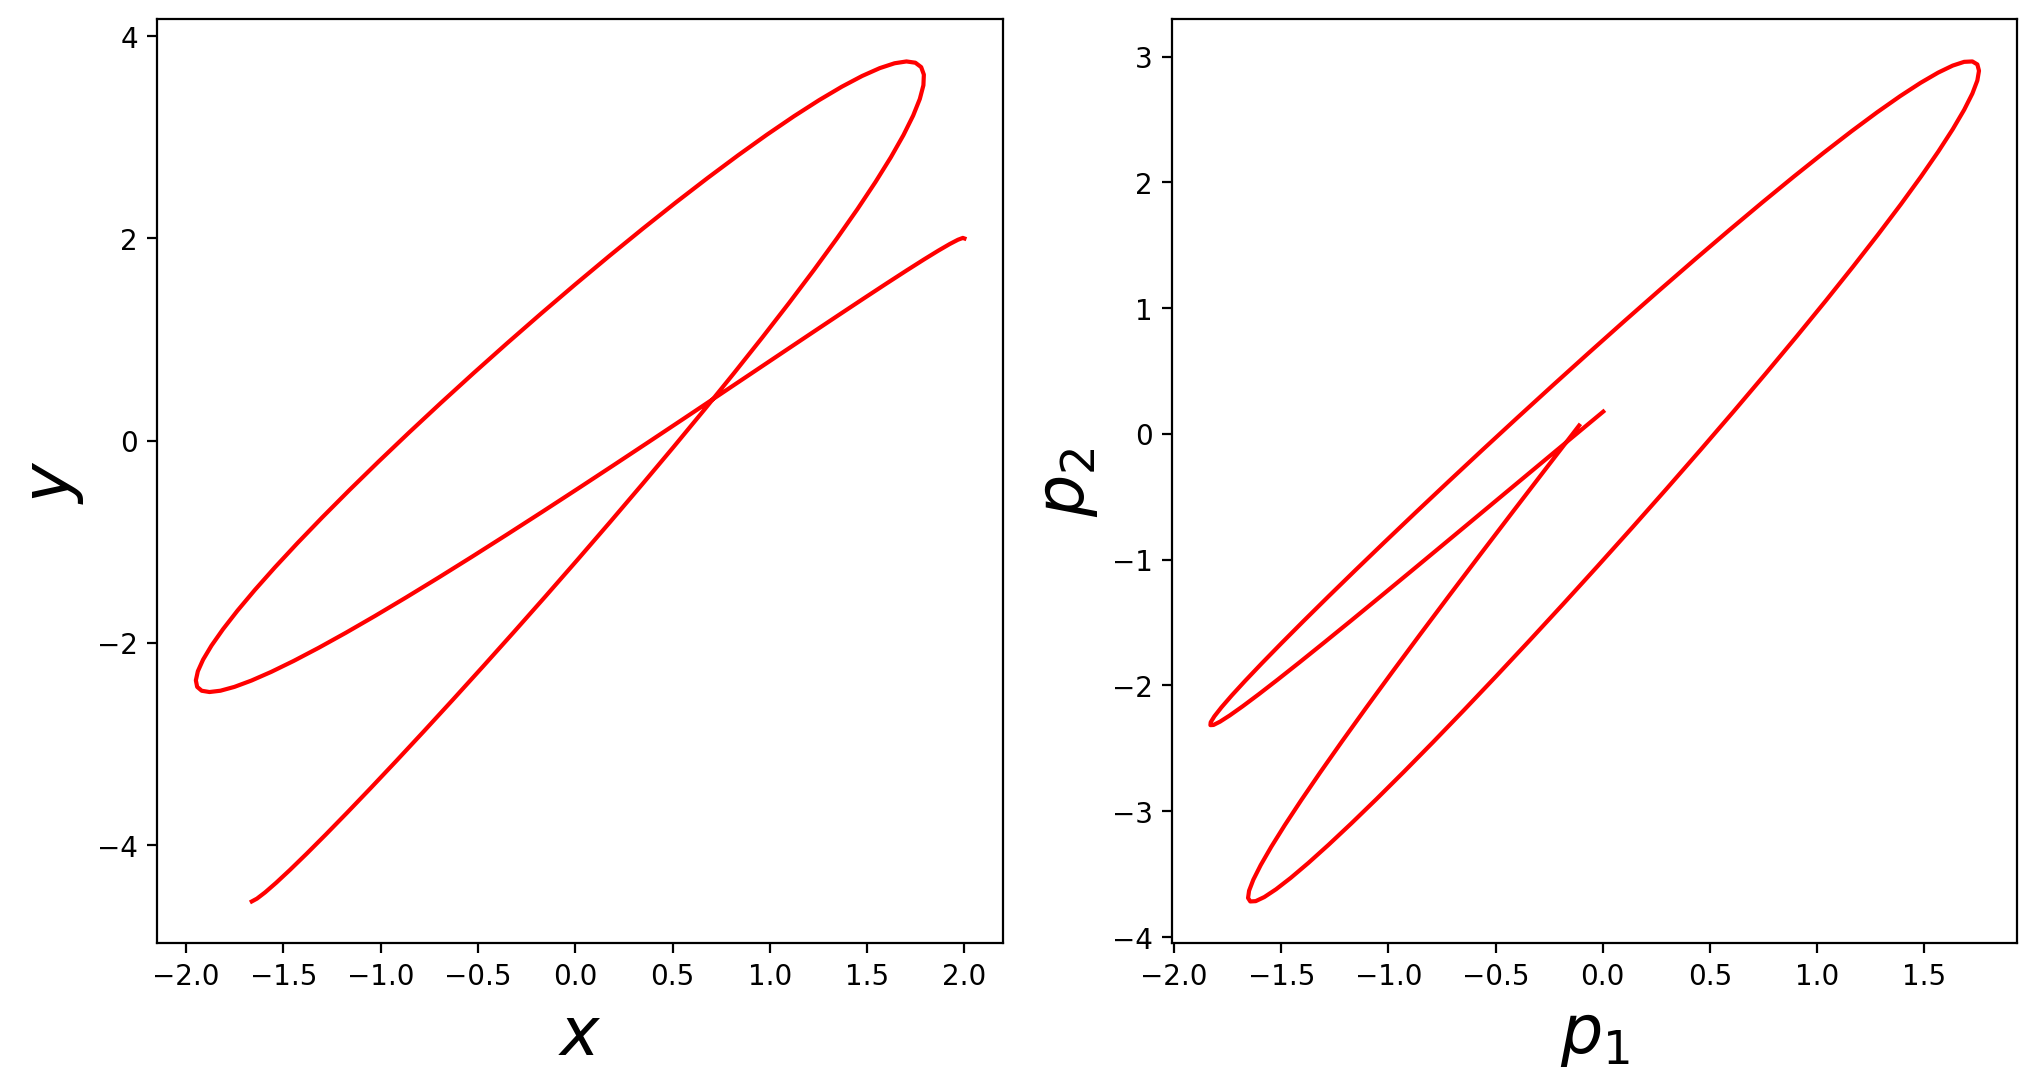

In [22]:
@interact(k=(100, K, 100))
def plot_fn(k=100):
    fig = figure(1, [12, 6])
#     pcolor(X, Y, exp(Z))
    fig.add_subplot(121)
    plot(Xsol[:k, 0], Xsol[:k, 1], 'r')
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$y$', fontsize=24);
    fig.add_subplot(122)
    plot(Psol[:k, 0], Psol[:k, 1], 'r')
    xlabel(r'$p_1$', fontsize=24)
    ylabel(r'$p_2$', fontsize=24);

# Example of Hamiltonian velocity jump MCMC in Python

<ipython-input-23-5d09a5364358>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for k in arange(K):


acceptance ratio: [0.412 0.426 0.434 0.416]
mean number of leap frog steps: [405.39]


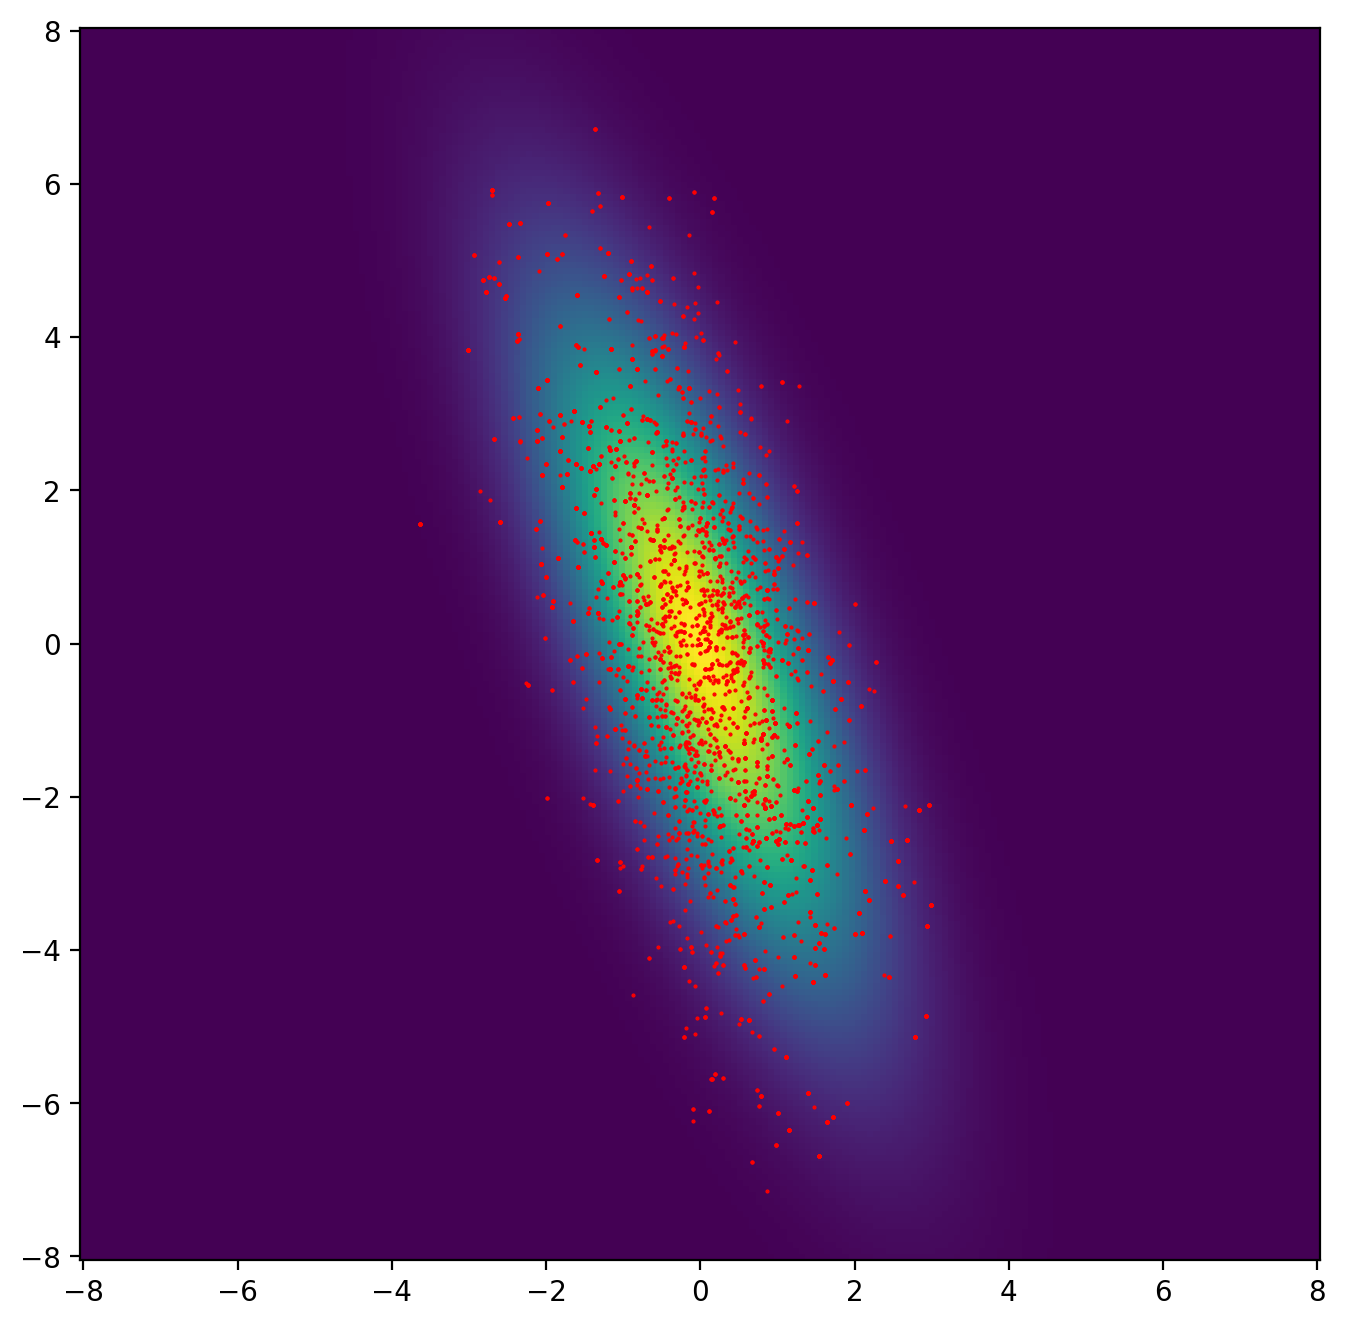

In [23]:
Nsteps = 1000
N_burn_in = 0
Nchains = 4
lam = 0.1
dt = 0.025

## initial guess
x = 0.*ones((Nchains, 2))

## Burn in phase
for n in arange(N_burn_in):
    p0 = normal(0, 1, [Nchains, 2])
    p = p0.copy()
    tau = -log(rand(1))/lam ## generate an exponential RV for time
    K = tau//dt
    p += 0.5*dt*gradL(x)
    for k in arange(K):
        x += dt*p
        p += dt*gradL(x)

Xchain = zeros((Nsteps, Nchains, 2))
Xchain[0, ...] = x ## use final value from burin-in as initial guess
probs = zeros((Nsteps, Nchains))
acceptances = ones((Nsteps, Nchains))
Kmean = 0.
for n in arange(Nsteps-1):
    p0 = normal(0, 1, [Nchains, 2])
    p = p0.copy()
    x0 = Xchain[n, ...]
    x = x0.copy()
    tau = -log(rand(1))/lam ## generate an exponential RV for time
    K = tau//dt
    Kmean += K

    ## forward Euler
    # for k in arange(K):
    #     gL = gradL(x)
    #     x += dt*p
    #     p += dt*gL

    ## Leap Frog
    p += 0.5*dt*gradL(x)
    for k in arange(K):
        x += dt*p
        p += dt*gradL(x)

    pMH = exp(H(x0, p0) - H(x, p))
    u = rand(Nchains)


    log_p_MH = H(x0, p0) - H(x, p)
    probs[n, :] = exp(log_p_MH)
    u = rand(Nchains)
    chi = 1.*(log(u) < log_p_MH)
    # chi = 1.*(u < exp(log_p_MH))
    acceptances[n+1, :] = chi
    Xchain[n+1, ...] = x0*(1 - chi[:, None]) + x*chi[:, None]

figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(Xchain[..., 0].flatten(), Xchain[..., 1].flatten(), 'r.', ms=1)
print('acceptance ratio:', acceptances.sum(axis=0)/Nsteps)
print('mean number of leap frog steps:', Kmean/Nsteps)

In [24]:
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[54.7058773 , 58.3308497 ],
       [53.66676943, 74.96425998],
       [69.22522106, 90.73171031],
       [90.35938939, 99.49668915]])>

In [25]:
print('mean:', Xchain.mean(axis=(0, 1)))
print('estimated covariance:\n', cov(Xchain.reshape(-1, 2).T))
print('true covariance:\n', inv(M))

mean: [-0.00833829 -0.15295338]
estimated covariance:
 [[ 1.57936141 -2.24273102]
 [-2.24273102  7.10073818]]
true covariance:
 [[ 1.89528992 -2.9273785 ]
 [-2.9273785   8.48189154]]


# HMC using Tensorflow Probability
Simple version: no step size adaptation (next week)

In [ ]:
Nsteps = 100
N_burn_in = 10
Nchains = 4
dt = 0.3

Xinit = 0.*ones((Nchains, 2))

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=L,
    num_leapfrog_steps=10,
    step_size=dt)

Xchain = tfp.mcmc.sample_chain(
    num_results=Nsteps,
    num_burnin_steps=N_burn_in,
    current_state=Xinit,
    trace_fn=None,
    kernel=kernel,
    parallel_iterations=4)
Xchain = array(Xchain)

figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(Xchain[..., 0].flatten(), Xchain[..., 1].flatten(), 'r.', ms=1)

In [ ]:
tfp.mcmc.effective_sample_size(Xchain)

In [ ]:
# tfp.mcmc.effective_sample_size(Xchain, filter_beyond_positive_pairs=True)

In [ ]:
print('mean:', Xchain.mean(axis=(0, 1)))
print('estimated covariance:\n', cov(Xchain.reshape(-1, 2).T))
print('true covariance:\n', inv(M))